In [1]:
"""
In order to run the code as is, you will need scipy, pandas and tqdm installed 
(although tqdm is only needed for the progress bar, and pandas is only for the autocorrelation function)
All of these can be installed (on linux) from the command interface using 'pip'
""" 

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from gibbsrank import gibbs_sample
from eprank import eprank
import pandas as pd
from cw2 import sorted_barplot

We first need to load the data, stored in "tennis_data.mat". The data consists of an array, $W$ containing the names of each player, and an array, G, containing the results of all of the matches in the season. 

In [2]:
# load data
data = sio.loadmat('tennis_data.mat')

# Array containing the names of each player
W = data['W']

# loop over array to format more nicely
for i, player in enumerate(W):
    W[i] = player[0]
    
# Array of size num_games x 2. The first entry in each row is the winner of game i, the second is the loser
G = data['G'] - 1    # I think minus 1 is to adapt for the fact that python index starts at 0.
                     # Hence the player id's are from 0 to 106.

# Number of players
M = W.shape[0]

# Number of Games
N = G.shape[0]

print('M =', M)
print('N =', N)

M = 107
N = 1801


In [3]:
names = ['Novak-Djokovic', 'Rafael-Nadal', 'Roger-Federer', 'Andy-Murray']
ATP_top_players = []

for name in names:
    index = np.where(W == name)[0][0]
    ATP_top_players.append(index)

print(ATP_top_players)

[15, 0, 4, 10]


# a) Gibbs sampling (This may take a minute)

In [4]:
'''
# set seed for reproducibility
seed = 0
np.random.seed(seed)

# number of iterations
num_iters = 30000

# perform gibbs sampling, skill samples is an "num_players x num_samples" array
skill_samples = gibbs_sample(G, M, num_iters)#, random_nums)

np.save('a_result/skill_samples'+str(seed)+'(30000iters).npy', skill_samples)
'''
None

In [5]:
import numpy as np
import matplotlib.pyplot as plt

seed = 0

skill_samples = np.load('a_result/skill_samples'+str(seed)+'.npy')
# skill_samples = np.load('a_result/skill_samples'+str(seed)+'(11000iters).npy')
skill_samples

array([[ 0.74497722,  0.86013712,  0.87339386, ...,  1.39476782,
         1.22839064,  1.60935757],
       [ 0.08228189,  0.09047983, -0.09037934, ...,  0.21062495,
         0.42631743,  0.22437813],
       [ 0.40130912,  0.37989297,  0.53391853, ...,  0.91349756,
         0.61999243,  1.2049945 ],
       ...,
       [-0.29915431, -0.43542717, -1.29633563, ..., -1.18123496,
        -1.60986612, -0.8782213 ],
       [-0.50318867,  1.1142377 , -1.21534205, ...,  0.10268161,
         0.38477257, -0.80246736],
       [-1.05189534, -0.57774341, -0.53096967, ..., -1.37878223,
        -0.07893736, -0.73862442]])

## Sampled skills of ATP top four players

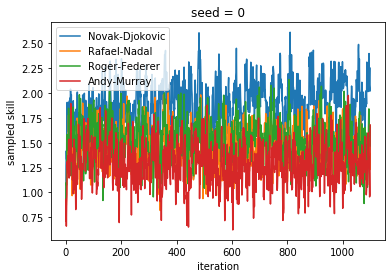

In [6]:
# %matplotlib notebook
%matplotlib inline

# Plot sampled skill for player p against Gibbs iteration.
# for p in range(107):
#     plt.plot(skill_samples[p,:])
for p in ATP_top_players:
#     plt.figure()
    plt.plot(skill_samples[p,:], label = W[p][0])
    plt.xlabel('iteration')
    plt.ylabel('sampled skill')
#     plt.legend()

plt.title('seed = '+str(seed))
plt.legend()

## auto-correlation of all players --> determine thinning interval

player_longest_autocor = 15


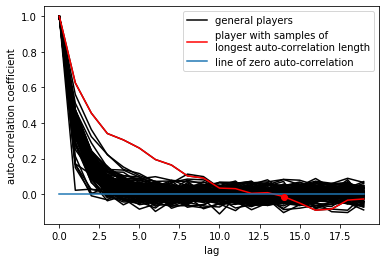

In [7]:
# %matplotlib notebook
%matplotlib inline

# Code for plotting the autocorrelation function for player p
num_lags = 20

longest_autocor_lag6 = 0
player_longest_autocor = None
longest_autocor = None

for p in range(M):
    autocor = np.zeros(num_lags)
    for i in range(num_lags):
        autocor[i]=pd.Series.autocorr(pd.Series(skill_samples[p,:]),lag=i)
    
    if p == 0:
        plt.plot(autocor, 'k', label = 'general players')
    else:
        plt.plot(autocor, 'k')

    plt.xlabel('lag')
    plt.ylabel('auto-correlation coefficient')
    
    if autocor[6] > longest_autocor_lag6:
        player_longest_autocor = p
        longest_autocor_lag6 = autocor[6]
        longest_autocor = autocor

    
        
print('player_longest_autocor =', player_longest_autocor)

plt.plot(longest_autocor, 'r', label = 'player with samples of \nlongest auto-correlation length')
plt.plot(np.linspace(0,num_lags-1,num_lags), [0]*num_lags, label = 'line of zero auto-correlation')
plt.plot(14, longest_autocor[14], 'ro')

plt.legend()

plt.savefig('a_result/a_result_longest_AC_length.jpg')

## iteration for sample of all players to reach IQR --> determine burn-in time.

8


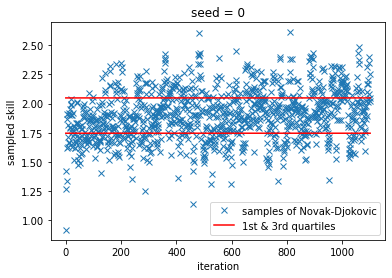

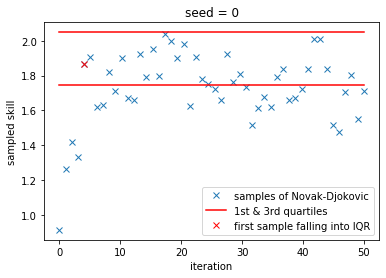

In [8]:
# %matplotlib notebook
%matplotlib inline

# Keeping only every 10th sample.

# i_thinning = 15
# skill_samples_thinned = skill_samples[:,::i_thinning]
# n_thinned = skill_samples_thinned.shape[1]

iters_burn_in = []    # will have dimension M.

num = 50    # how many samples to show in the graph
num_iters = 30000

for p in range(M):
# for p in np.concatenate((ATP_top_players,[90])):
    
    q1, q3= np.percentile(sorted(skill_samples[p,:]),[25,75])
    
    for i in range(num_iters):
        if skill_samples[p,:][i] > q1 and skill_samples[p,:][i] < q3:
            iters_burn_in.append(i)
            break
        else:
            pass
    
    i = iters_burn_in[p]
    
    if p == 15:
        num = 1100

        plt.figure()
        plt.plot(np.linspace(0,num,num),skill_samples[p,:num], 'x', label = 'samples of ' + W[p][0])
        plt.plot(np.linspace(0,num,num), [q1]*num, 'r', label = '1st & 3rd quartiles')
        # np.linspace(0, n_thinned-1, n_thinned)
        plt.plot(np.linspace(0,num,num), [q3]*num, 'r')
        plt.xlabel('iteration')
        plt.ylabel('sampled skill')
        plt.legend()
        plt.title('seed = '+str(seed))
        plt.savefig('a_result/a_result_burn_in1.jpg')

        num = 50

        plt.figure()

        plt.plot(np.linspace(0,num,num),skill_samples[p,:num], 'x', label = 'samples of ' + W[p][0])
        plt.plot(np.linspace(0,num,num), [q1]*num, 'r', label = '1st & 3rd quartiles')
        plt.plot(i ,skill_samples[p,:][i], 'rx', label = 'first sample falling into IQR')
        plt.plot(np.linspace(0,num,num), [q3]*num, 'r')
        plt.xlabel('iteration')
        plt.ylabel('sampled skill')
        plt.legend()
        plt.title('seed = '+str(seed))
        plt.savefig('a_result/a_result_burn_in2.jpg')

print( max(np.array(iters_burn_in) + 1) )

## Thinning

In [9]:
# %matplotlib notebook
%matplotlib inline

# Keeping only every 10th sample.

skill_samples = np.load('a_result/skill_samples0(30000iters).npy')

i_thinning = 15
skill_samples_thinned = skill_samples[:,::i_thinning]
n_thinned = skill_samples_thinned.shape[1]

'''
# for p in ATP_top_players:
for p in np.concatenate((ATP_top_players,[90])):
    plt.figure()
    
    plt.plot(np.linspace(0,1100,n_thinned),skill_samples_thinned[p,:], 'x', label = 'samples of ' + W[p][0])
    q1, q3= np.percentile(sorted(skill_samples_thinned[p,:]),[25,75])
    plt.plot(np.linspace(0,1100,n_thinned), [q1]*n_thinned, 'r', label = '1st & 3rd quartiles')
    # np.linspace(0, n_thinned-1, n_thinned)
    plt.plot(np.linspace(0,1100,n_thinned), [q3]*n_thinned, 'r')
    plt.xlabel('iteration')
    plt.ylabel('sampled skill')
    plt.legend()
    plt.title('seed = '+str(seed))
#     print(skill_samples_thinned[p,:])

# --------------------------------------------------------------------------------------

# for p in ATP_top_players:
#     q1, q3= np.percentile(sortedted(skill_samples_thinned[p,:]),[25,75])
'''
None

D:\Anaconda3\Lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


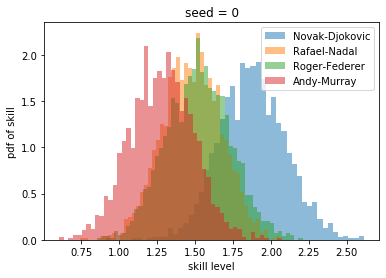

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# p = ATP_top_players[-1]
for p in ATP_top_players:
#     plt.figure()
    plt.hist(skill_samples_thinned[p,:], bins=50, label = W[p][0], alpha = 0.5, normed=True)
    plt.title('seed = '+str(seed))

#     plt.figure()
#     sns.boxplot(skill_samples_thinned[p,:])
#     plt.legend([W[p][0]])
#     plt.title('seed = '+str(seed))

plt.legend()
plt.xlabel('skill level')
plt.ylabel('pdf of skill')

plt.savefig('a_result/a_hist_samples')

# b) EP ranking

In [11]:
# Ps = np.zeros(M)
# print(Ps)
# print(G)
# print(Ps[G])

### Alter the code in eprank so that it returns two matrices with each column being mean_skills and precision_skills respectively.

In [12]:
num_iters = 50
# run message passing algorithm, returns mean and precision for each player
mean_player_skills, precision_player_skills = eprank(G, M, num_iters)

np.save('b_result/mean_skills_iters.npy', mean_player_skills)
np.save('b_result/precisions_iters.npy', precision_player_skills)

In [13]:
mean_player_skills.shape

(107, 50)

## Judging convergence of MP

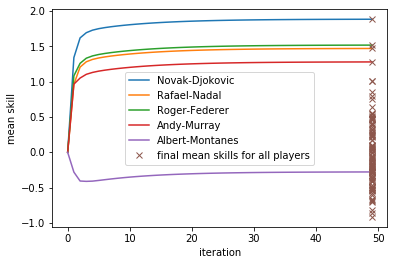

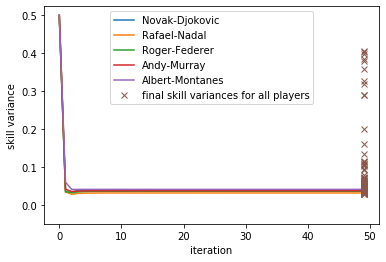

In [14]:
%matplotlib inline

# for p in ATP_top_players:
for p in np.concatenate((ATP_top_players,[90])):
# for p in range(M):
    plt.figure(1)
    plt.plot(mean_player_skills[p,:], label = W[p][0])
    
    plt.figure(2)
    plt.plot(1./precision_player_skills[p,:], label = W[p][0])

plt.figure(1)
plt.plot([num_iters-1]*M, mean_player_skills[:,-1], 'x', label = 'final mean skills for all players')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('mean skill')
plt.savefig('b_result/b_result_MP_mean_converge')

plt.figure(2)
plt.plot([num_iters-1]*M, 1./precision_player_skills[:,-1], 'x', label = 'final skill variances for all players')
plt.ylim(-0.05)
plt.legend()
plt.xlabel('iteration')
plt.ylabel('skill variance')
plt.savefig('b_result/b_result_MP_var_converge')

means = 1.2795777646457323 , 1.281147401113124
stds = 0.19307661596411882 , 0.20844341425819615


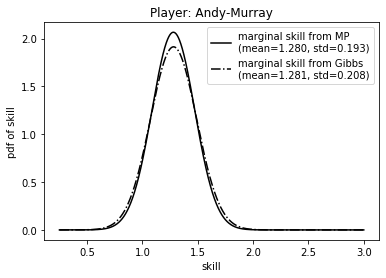

In [18]:
# Gaussian of each ATP top players

from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

final_mean_skills = mean_player_skills[:,-1]
final_skill_variances = 1./precision_player_skills[:,-1]

# for p in range(M):
for p in [ATP_top_players[3]]:
# for p in ATP_top_players:

    
    plt.figure()
    
    mean = final_mean_skills[p]
    std = np.sqrt(final_skill_variances[p])
    
    x = np.linspace(0.25,3,10000)
#     x = np.linspace(-5,+5,10000)
#     plt.plot(x,norm.pdf(x,mean,std))
    plt.plot(x, norm.pdf(x, mean, std), 'k', label = 'marginal skill from MP\n(mean=1.280, std=0.193)')
    
#     plt.hist(skill_samples_thinned[p,:], bins=50, label = W[p][0], alpha = 0.5, normed=True)
    
    mean1_apx = np.mean(skill_samples_thinned[p,:])
    var1_apx = np.var(skill_samples_thinned[p,:])
    plt.plot(x, norm.pdf(x, mean1_apx, np.sqrt(var1_apx)), 'k-.', label = 'marginal skill from Gibbs\n(mean=1.281, std=0.208)')
    
    print('means =', mean, ',', mean1_apx)
    print('stds =', std, ',', np.sqrt(var1_apx))
    
    plt.title('Player: '+ W[p][0])

    plt.legend()
    plt.xlabel('skill')
    plt.ylabel('pdf of skill')
    
    plt.savefig('marginal_Gibbs_vs_MP.jpg')